In [21]:
%%capture o
!cd build && make
## all versions can be found in the git history if you want to recompile the execs (notebook may be altered)
## the cmake is build by running the line contained in build.sh

In [22]:
import os
import subprocess
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
repeat = 20
dna = [500, 5000, 50000, 500000, 5000000] # -g
size = [32, 128, 256, 1024]# -w -h
mut_rate = [0.0001, 0.00001, 0.000001]# -m
data = pd.DataFrame(columns=['size', 'dna_size', 'mut_rate', 'time', 'version'])


In [24]:
for s in size:
    for d in dna:
        for m in mut_rate:
            for r in range(repeat):
                args = ("./execs/micro_aevol_cpu_v0", "-g", str(d), "-w", str(s), "-h", str(s), "-r", str(r), "-m", str(m))
                time_s = time.time()
                popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                popen.wait()
                time_e = time.time() - time_s
                data.loc[len(data.index)] = [s, d, m, time_e, 'version_0']

                args = ("./execs/micro_aevol_cpu_v1", "-g", str(d), "-w", str(s), "-h", str(s), "-r", str(r), "-m", str(m))
                time_s = time.time()
                popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                popen.wait()
                time_e = time.time() - time_s
                data.loc[len(data.index)] = [s, d, m, time_e, 'version_1']
                
                args = ("./execs/micro_aevol_cpu_v2", "-g", str(d), "-w", str(s), "-h", str(s), "-r", str(r), "-m", str(m))
                time_s = time.time()
                popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                popen.wait()
                time_e = time.time() - time_s
                data.loc[len(data.index)] = [s, d, m, time_e, 'version_2']

                args = ("./execs/micro_aevol_cpu_v3", "-g", str(d), "-w", str(s), "-h", str(s), "-r", str(r), "-m", str(m))
                time_s = time.time()
                popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                popen.wait()
                time_e = time.time() - time_s
                data.loc[len(data.index)] = [s, d, m, time_e, 'version_3']

                args = ("./execs/micro_aevol_cpu_v4", "-g", str(d), "-w", str(s), "-h", str(s), "-r", str(r), "-m", str(m))
                time_s = time.time()
                popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                popen.wait()
                time_e = time.time() - time_s
                data.loc[len(data.index)] = [s, d, m, time_e, 'version_4']

In [25]:
data = data.astype({'size':'int','dna_size':'int'})
data.head()

,size,dna_size,mut_rate,time,version
0,32,500,0.0001,0.014361,version_0
1,32,500,0.0001,0.013518,version_1
2,32,500,0.0001,0.012618,version_2
3,32,500,0.0001,0.012403,version_3
4,32,500,0.0001,0.013583,version_4


## Improvement 1 

As a first attempt of improvement we will try to leverage SIMD instructions inside of the DNA.cpp code. Some of these methods are where major bottlenecks are found since some of these functions are called thousands of times. Each one of these functions are looking for a certain pattern in the DNA through a simple for loop which is a great candidate for the use of vectorization. To ensure these work their best, we align the array and specify this alignment in the pragma directive.

### Curiosities

A lot of the time in these loops is spent checking whether we have looped back over the start of the DNA. Trying to store the size of the DNA instead of calling .size() repeatedly was consistently about twice as slow.

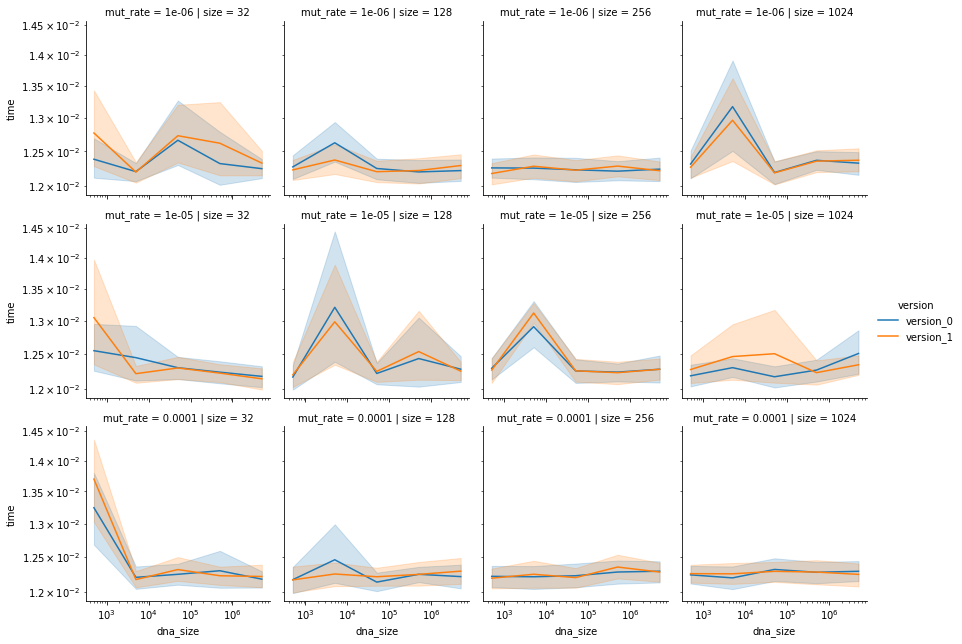

In [26]:
data_1 = data[(data['version'] == 'version_0') | (data['version'] == 'version_1')]
sea = sns.FacetGrid(data_1, col = "size", row='mut_rate', hue = "version" )
sea.map(sns.lineplot, "dna_size", "time").set(yscale='log').set(xscale='log')
sea.add_legend()

It's hard to see much difference between versions. This is probably explained by the fact that the intel compiler can spot and optimize these for loops very efficiently.

## Improvement 2
To further improve our previous code, we will try to get rid of the DNA looping problem. As the methods that read the DNA (eg. finding promoters, shine_dal..) are called much more often than those that modify it, it can be worth it to store the DNA in a more convenient manner. 
Instead of initializing this copy every single time, we create a new method called update_loop which allocates an array thrice the size of the DNA (three sequential copies). This way we can read both ends of the DNA by reading the middle copy of DNA. This copy has to be updated whenever DNA is updated but these cases are less frequent. (maybe could be mitigated by making an array of pointers to the other array).

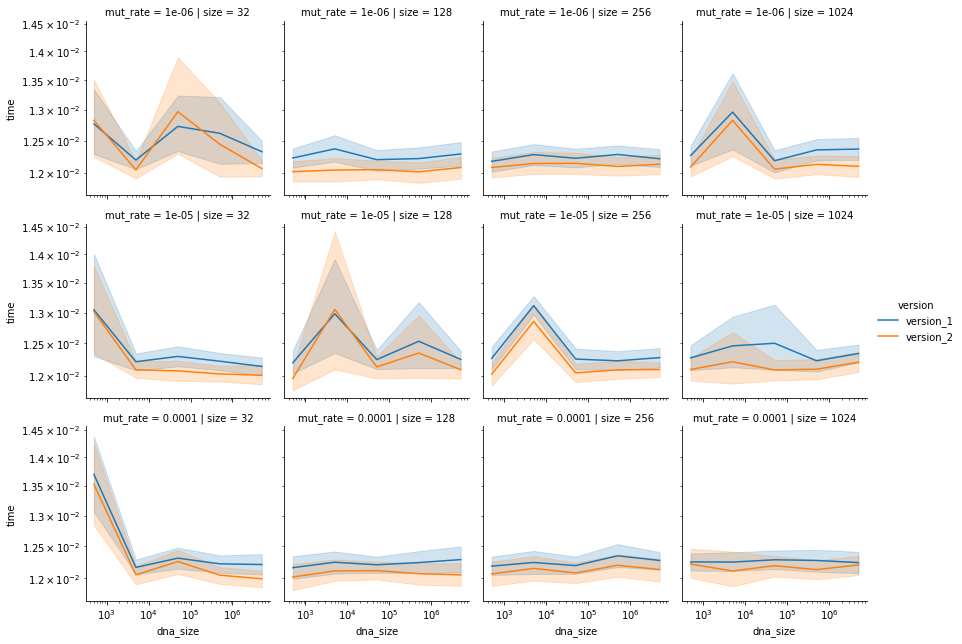

In [27]:
data_2 = data[(data['version'] == 'version_1') | (data['version'] == 'version_2')]
sea = sns.FacetGrid(data_2, col = "size", row='mut_rate', hue = "version" )
sea.map(sns.lineplot, "dna_size", "time").set(yscale='log').set(xscale='log')
sea.add_legend()

As we can see this change has brought a consistent drop in the average execution time no matter the parameters. There is some overlap in the error margin because the optimizations are done on a small chunk of code and there is a lot more code executed.

## ""Improvement"" 3

To go further in terms of time gains, we tried to parallelize the for loops which loop over every single organism in the grid since most of this processing can be done in parallel. 

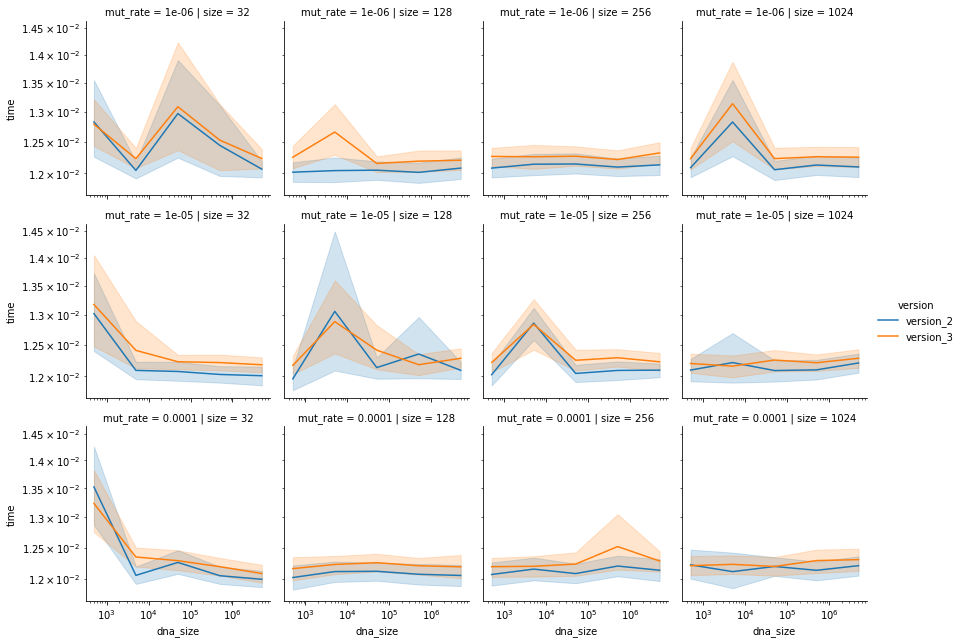

In [28]:
data_3 = data[(data['version'] == 'version_2') | (data['version'] == 'version_3')]
sea = sns.FacetGrid(data_3, col = "size", row='mut_rate', hue = "version" )
sea.map(sns.lineplot, "dna_size", "time").set(yscale='log').set(xscale='log')
sea.add_legend()

As we can see in the plots, the parallel version performed significantly worse in every single situation. This could be because aevol is a very memory bound program and the amount of processing done on each organism is too small to justify the opening and closing of threads. 

## "Improvement" 4

As the previous improvement didn't work we reversed them for this test. As a final test we thought to test the efficiency of the has_mutate() function. This function keeps track of wether or not an individual has mutated during the last step in order to re-do the evaluation if mutation has occured. If there has been no mutation the evaluation isnt normally repeated. In this version we evaluate every single element every time to see how significant this improvement is.

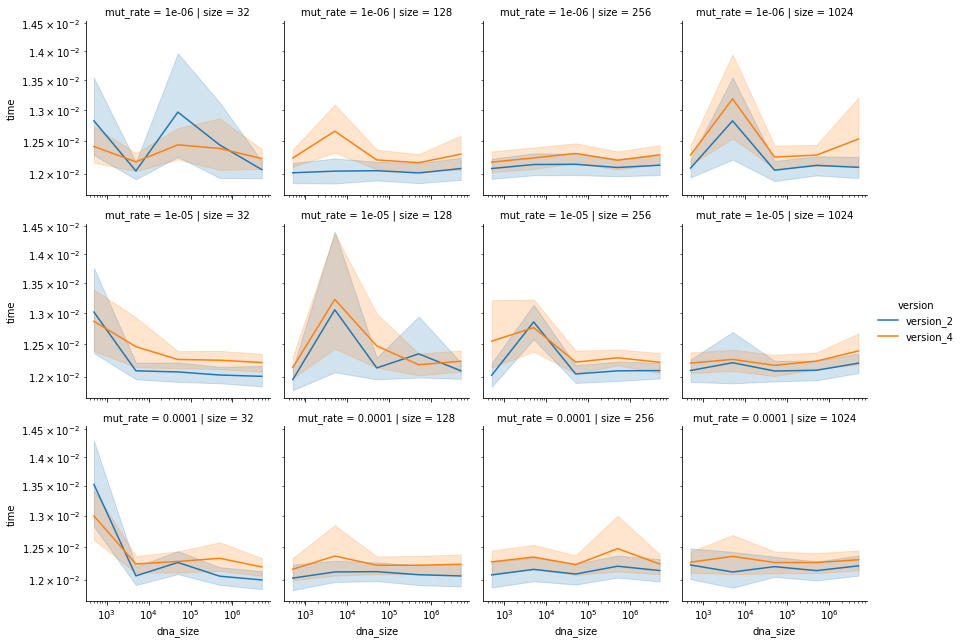

In [29]:
data_4 = data[(data['version'] == 'version_2') | (data['version'] == 'version_4')]
sea = sns.FacetGrid(data_4, col = "size", row='mut_rate', hue = "version" )
sea.map(sns.lineplot, "dna_size", "time").set(yscale='log').set(xscale='log')
sea.add_legend()

This also brought a massive decrase in performance. Keeping track of what really needs to be computed is a great way to drastically improve a program's runtime even if it means making a couple more comparaisons. 

# Data Vizualisation

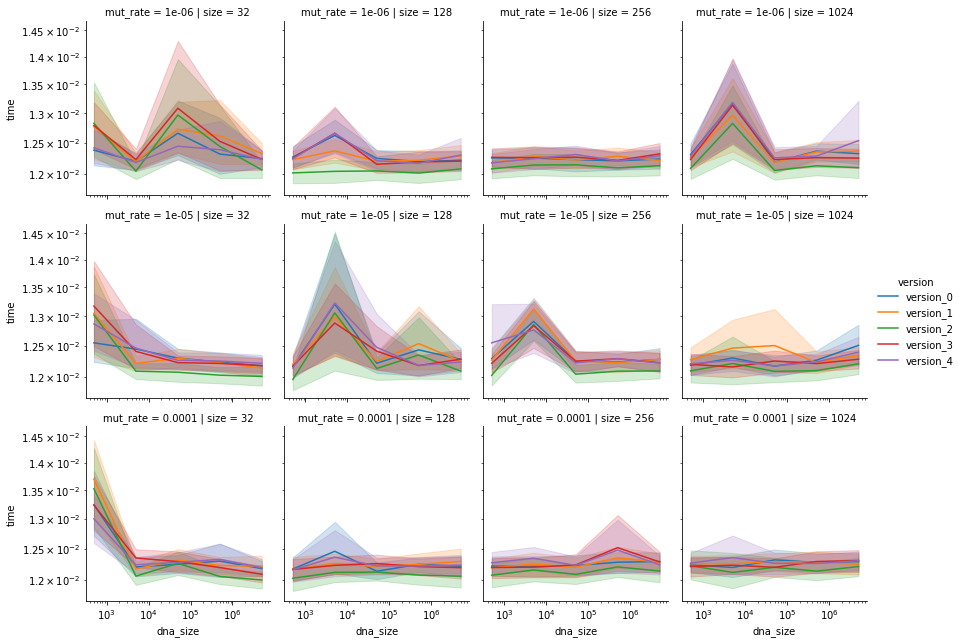

In [30]:
sea = sns.FacetGrid(data, col = "size", row='mut_rate', hue = "version" )
sea.map(sns.lineplot, "dna_size", "time").set(yscale='log').set(xscale='log')
sea.add_legend()

Results are pretty similar due to the intel compiler's ability to optimize certain bits of code pretty effectively. Even though we divided the functions with the most self_time's execution by two or three, they represent at most a couple of percent combined.